# Combine figure diseases MLR 
## UNFINISHED

Last modification: 02/12/2022

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime
import seaborn as sns

DATE = datetime.now().strftime("%Y-%m-%d")

In [108]:
display_info=True
date='2022_11_23'
ventile='covar_fix'
output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

## Read Diseases
diseases_dir ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/'


In [109]:
## Read MLR
betas=pd.read_csv(diseases_dir+'reg_betas_sup.csv', index_col=0)
log10p=pd.read_csv(diseases_dir+'reg_log10p_sup.csv', index_col=0)
betas = betas.astype('float64') # in case betas was coded as object type

In [110]:


SUPPLEMENTARY_LABELS='tau1_all,tau1_artery,tau1_vein,ratio_AV_DF,tau2_all,tau2_artery,tau2_vein,tau4_all,tau4_artery,tau4_vein,D_std,D_A_std,D_V_std,D_CVMe,D_CVMe_A,D_CVMe_V,sd_mean_size,N_median_main_arteries,N_median_main_veins,arcLength_artery,arcLength_vein,bifurcations,VD_orig_all,VD_orig_artery,VD_orig_vein,ratio_VD,FD_all,FD_artery,FD_vein,mean_angle_taa,mean_angle_tva,eq_CRAE,eq_CRVE,median_CRAE,median_CRVE,CRAE,CRVE,ratio_CRAE_CRVE,ratio_median_CRAE_CRVE,ratio_standard_CRE,medianDiameter_all,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
SUPPLEMENTARY_NAMES='tortuosity,A tortuosity,V tortuosity,ratio tortuosity,tortuosity2,A tortuosity2,V tortuosity2,tortuosity3,A tortuosity3,V tortuosity3,std diameter,A std diameter,V std diameter,CVMe diameter,A CVMe diameter,V CVMe diameter,std norm diameter,A num main,V num main,A arc length,V arc length,bifurcations,vascular density,A vascular density,V vascular density,ratio vascular density,fractal dimension,A fractal dimension,V fractal dimension,A temporal angle,V temporal angle,A central retinal eq,V central retinal eq,A main diameter,V main diameter,A central retinal eq2,V central retinal eq2,ratio central retinal eq,ratio main diameter,ratio central retinal eq2,median diameter,A median diameter,V median diameter,ratio median diameter'

##### MAIN PHENOTYPES
MAIN_LABELS='mean_angle_taa,mean_angle_tva,tau1_vein,tau1_artery,ratio_AV_DF,eq_CRAE,ratio_CRAE_CRVE,D_A_std,D_V_std,eq_CRVE,ratio_VD,VD_orig_artery,bifurcations,VD_orig_vein,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
MAIN_NAMES='A temporal angle,V temporal angle,V tortuosity,A tortuosity,ratio tortuosity,A central retinal eq,ratio central retinal eq,A std diameter,V std diameter,V central retinal eq,ratio vascular density,A vascular density,bifurcations,V vascular density,A median diameter,V median diameter,ratio median diameter'
type_used= 'sup' #sup  'main'

if type_used=='main':
    old = MAIN_LABELS
    new = MAIN_NAMES
elif type_used=='sup':
    old = SUPPLEMENTARY_LABELS
    new = SUPPLEMENTARY_NAMES

list_old_phenotypes=list(old.split(","))
list_new_phenotypes=list(new.split(","))


file_info_name='/SSD/home/sofia/retina-phenotypes/complementary/pheno_diseases_info.csv'

inf = pd.read_csv(file_info_name)

### Read diseases info from csv
#inf.columns
inf_LR=inf[inf['main_supl']=='main']
# #inf_LR=inf[inf['name_LR'].notnull()]
inf_cox=inf[inf['main_supl']=='hr']

##Take list for the old and new names
list_diseases_LR = inf_LR['name_LR'].values
list_diseases_LR_new = inf_LR['final_name'].values + ' '+ inf_LR['round_N_cases_LR_cox'].values

list_diseases_cox = inf_cox['name_LR'].values
list_diseases_cox_new = inf_cox['final_name'].values + ' '+ inf_cox['round_N_cases_LR_cox'].values

## To spit in Linear and logistic regressions: ## categorical is not used 
inf_LinearR_bin = inf[inf['dtype']=='con']
inf_LinearR_bin = inf_LinearR_bin[inf_LinearR_bin['main_supl']=='main']
list_diseases_LinearR = inf_LinearR_bin['name_LR'].values
list_diseases_LinearR_new = inf_LinearR_bin['final_name'].values + ' '+ inf_LinearR_bin['round_N_cases_LR_cox'].values

inf_LogisticR_bin = inf[inf['dtype']=='bin']
inf_LogisticR_bin = inf_LogisticR_bin[inf_LogisticR_bin['main_supl']=='main']

list_diseases_LogistR = inf_LogisticR_bin['name_LR'].values
list_diseases_LogistR_new = inf_LogisticR_bin['final_name'].values  + ' '+ inf_LogisticR_bin['round_N_cases_LR_cox'].values


inf_LogisticR_bin_con = inf[inf['dtype']=='bin_con']
inf_LogisticR_bin_con = inf_LogisticR_bin_con[inf_LogisticR_bin_con['main_supl']=='hr'] 

list_diseases_LogistR_both = inf_LogisticR_bin_con['name_LR'].values #+ inf_LogisticR_bin_con['name_cox'].values
list_diseases_LogistR_both_new = inf_LogisticR_bin_con['final_name'].values  + ' '+ inf_LogisticR_bin_con['round_N_cases_LR_cox'].values


In [111]:
##Change the name of the columns and index in beta, log10 and cox:
def filter_rename_col_index(df_, l_pehos_old, l_phenos_new, l_diseases_old, l_diseases_new, filtered_by):
    if filtered_by==True:
        df_ =df_.loc[l_pehos_old]
    else:
        df_ = df_.T
        df_ =df_.loc[l_diseases_old]
        df_ = df_.T

    df_.rename(index=dict(zip(l_pehos_old, l_phenos_new)), inplace=True)
    #print(df_)
    df_.rename(columns=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
    return df_

## linear and logistic split

list_logistic_cox = [j for i in [list(list_diseases_LogistR), list(list_diseases_cox)] for j in i] 
list_logistic_cox_new = [j for i in [list(list_diseases_LogistR_new), list(list_diseases_cox_new)] for j in i] 

log10p_logistic = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_logistic_cox, list_logistic_cox_new, False)
betas_logistic = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_logistic_cox, list_logistic_cox_new, False)


log10p_linear = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_diseases_LinearR, list_diseases_LinearR_new, False)
betas_linear = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_diseases_LinearR, list_diseases_LinearR_new, False)

print( len(log10p_logistic), len(log10p_linear) )


44 44


In [112]:
import matplotlib.gridspec as gridspec


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

###LinearR
Bonf_thresh_linear = -np.log10(0.05 / (log10p_linear.shape[0] * log10p_linear.shape[1]))
Bonf_thresh2_linear = -np.log10(0.001 / (log10p_linear.shape[0] * log10p_linear.shape[1]))

linear_log10p_copy = log10p_linear.copy()
linear_log10p_copy2 = log10p_linear.copy()
linear_log10p_copy3 = log10p_linear.copy()

linear_log10p_copy= (linear_log10p_copy>Bonf_thresh_linear).replace({True:'*', False:''})
linear_log10p_copy2= (linear_log10p_copy2>Bonf_thresh2_linear).replace({True:'*', False:''})
linear_log10p_copy3 =linear_log10p_copy+linear_log10p_copy2

###LogisticR
Bonf_thresh_log = -np.log10(0.05 / (log10p_logistic.shape[0] * log10p_logistic.shape[1]))
Bonf_thresh2_log = -np.log10(0.001 / (log10p_logistic.shape[0] * log10p_logistic.shape[1]))

log_log10p_copy = log10p_logistic.copy()
log_log10p_copy2 = log10p_logistic.copy()
log_log10p_copy3 = log10p_logistic.copy()

log_log10p_copy= (log_log10p_copy>Bonf_thresh_log).replace({True:'*', False:''})
log_log10p_copy2= (log_log10p_copy2>Bonf_thresh2_log).replace({True:'*', False:''})
log_log10p_copy3 =log_log10p_copy+log_log10p_copy2



[Text(0.5, 0, 'tortuosity'),
 Text(1.5, 0, 'A tortuosity'),
 Text(2.5, 0, 'V tortuosity'),
 Text(3.5, 0, 'ratio tortuosity'),
 Text(4.5, 0, 'tortuosity2'),
 Text(5.5, 0, 'A tortuosity2'),
 Text(6.5, 0, 'V tortuosity2'),
 Text(7.5, 0, 'tortuosity3'),
 Text(8.5, 0, 'A tortuosity3'),
 Text(9.5, 0, 'V tortuosity3'),
 Text(10.5, 0, 'std diameter'),
 Text(11.5, 0, 'A std diameter'),
 Text(12.5, 0, 'V std diameter'),
 Text(13.5, 0, 'CVMe diameter'),
 Text(14.5, 0, 'A CVMe diameter'),
 Text(15.5, 0, 'V CVMe diameter'),
 Text(16.5, 0, 'std norm diameter'),
 Text(17.5, 0, 'A num main'),
 Text(18.5, 0, 'V num main'),
 Text(19.5, 0, 'A arc length'),
 Text(20.5, 0, 'V arc length'),
 Text(21.5, 0, 'bifurcations'),
 Text(22.5, 0, 'vascular density'),
 Text(23.5, 0, 'A vascular density'),
 Text(24.5, 0, 'V vascular density'),
 Text(25.5, 0, 'ratio vascular density'),
 Text(26.5, 0, 'fractal dimension'),
 Text(27.5, 0, 'A fractal dimension'),
 Text(28.5, 0, 'V fractal dimension'),
 Text(29.5, 0, 'A tem

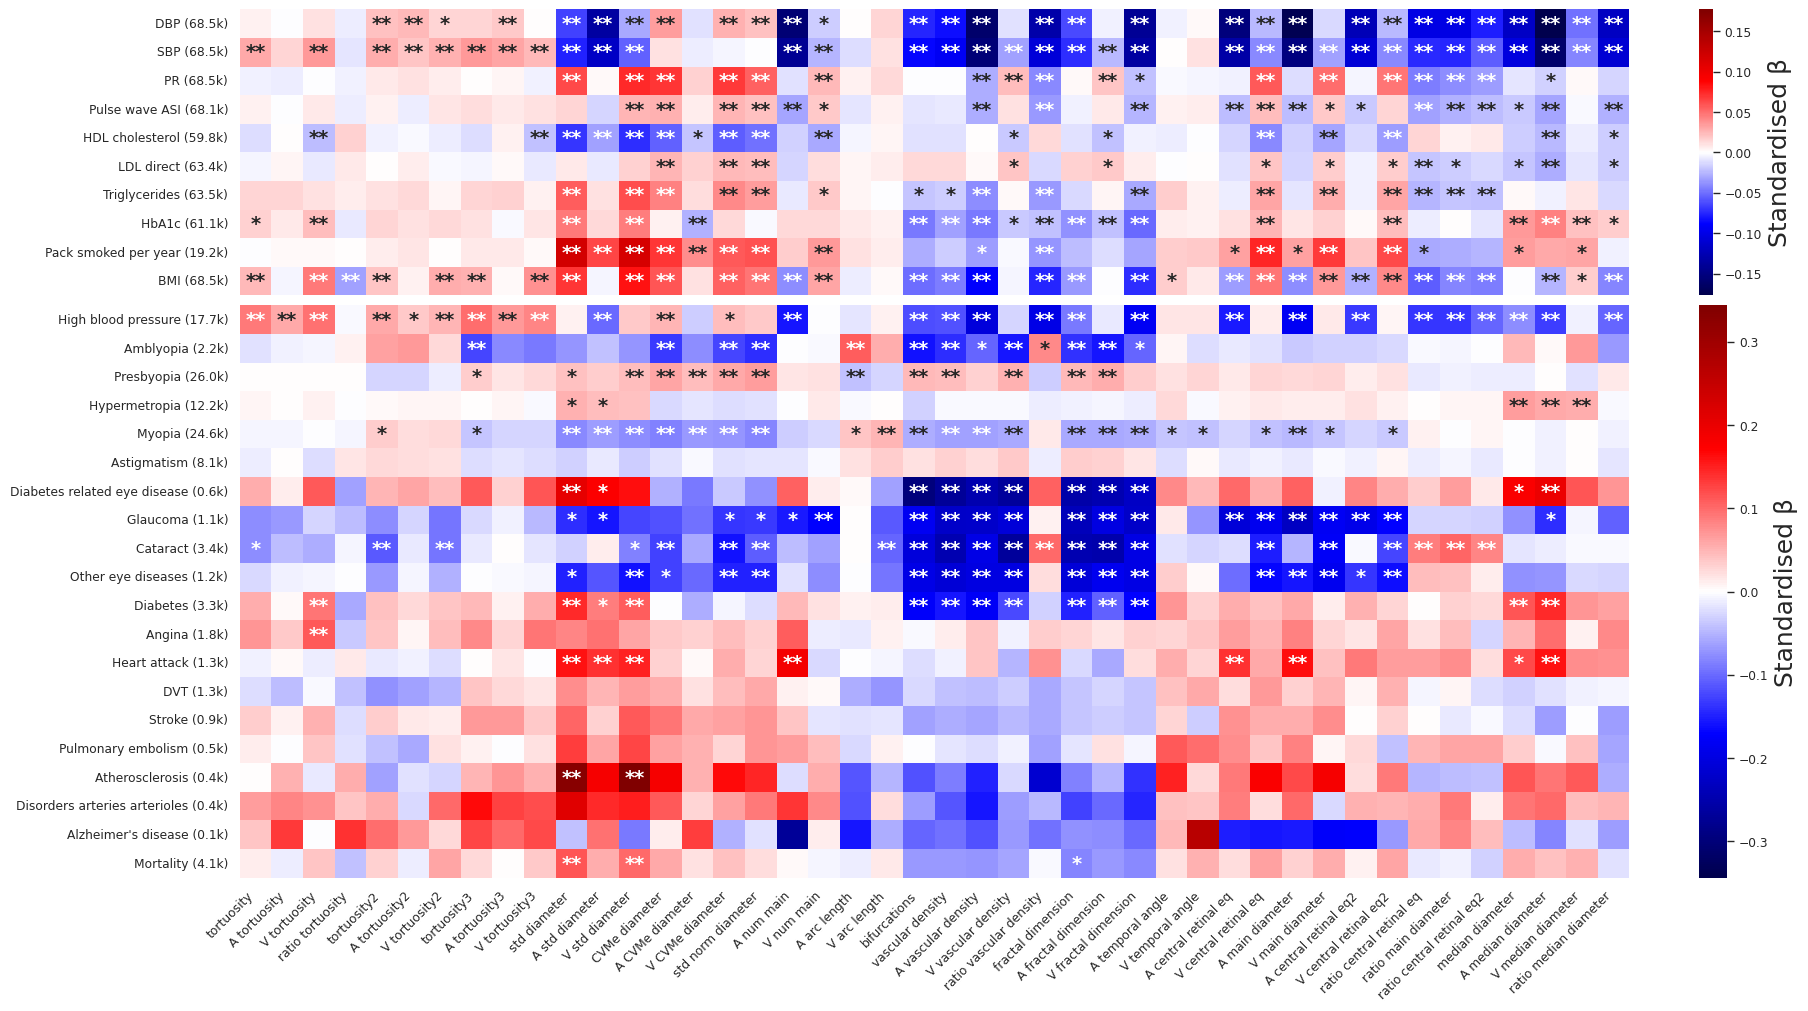

In [135]:
figsize_val=(18, 10)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_val, gridspec_kw={'height_ratios': [0.7, 1.4]})

#ax1 = plt.subplot(311)

#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '14'
fig1 = sns.heatmap(betas_linear.T, 
            annot=linear_log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_linear.T).max().max(), ## combined
            vmax=abs(betas_linear.T).max().max(), 
            #vmin=-abs(betas_linear).max().max(), ## normal
            #vmax=abs(betas_linear).max().max(), 
            cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
#fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right', visible=False)

fig2 = sns.heatmap(betas_logistic.T, 
            annot=log_log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas_logistic.T).max().max(), 
            vmax=abs(betas_logistic.T).max().max(), 
            cmap='seismic', alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax2)
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')
#plt.ylabel('Logistic regresion')



In [ ]:
# import seaborn as sns
# from matplotlib import cm
# from matplotlib import pyplot as plt
# import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# ### You need to: 
# ## - delete the nans, 
# ## - diagonal to 0, and
# ## - abs(linkage)

# df_2_nan = df_corr
# df_2_nan=df_2_nan.replace(np.nan,1)
# #print('Count nans: ', df2.isna().sum().sum(), df_2_nan.isna().sum().sum())
# # pairwise distance: define distance between two perfectly negatively correlated traits as 0
# df_otro = 1 - abs(df_2_nan) 
# ## diagonal same value:
# df_otro.values[[np.arange(df_otro.shape[0])]*2] = 0

# linkage = hc.linkage(sp.distance.squareform(df_otro), method='average')
# lik_abs= abs(linkage)
# h = sns.clustermap(df_otro, row_linkage=lik_abs, col_linkage=lik_abs, cmap=cm.get_cmap('viridis_r'), figsize=(20,20), vmin=0, vmax=1)
# h.ax_row_dendrogram.set_visible(False)
# #h.ax_heatmap.xaxis.tick_top()
# h.ax_heatmap.tick_params(axis='x', rotation=90)


In [130]:
simple_fig_plot= False
if simple_fig_plot==True:
    ## This colours by beta and annotates Bonferroni-significant models with an asterisk
    ###MLR
    Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))
    Bonf_thresh2 = -np.log10(0.001 / (log10p.shape[0] * log10p.shape[1]))

    log10p_copy = log10p.copy()
    log10p_copy2 = log10p.copy()
    log10p_copy3 = log10p.copy()

    log10p_copy= (log10p_copy>Bonf_thresh).replace({True:'*', False:''})
    log10p_copy2= (log10p_copy2>Bonf_thresh2).replace({True:'*', False:''})
    log10p_copy3 =log10p_copy+log10p_copy2

    fig_dim = (18.0, 10.0)
    fig, ax = plt.subplots(figsize=fig_dim)
    sns.set_style("white")
    sns.set(font_scale = 18)
    sns.set_context("paper", rc={"axes.labelsize":18})

    fig = sns.heatmap(betas.T, 
                annot=log10p_copy3.T, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
                cbar=True, #If not False
                fmt="", annot_kws={'weight': 'bold'}, 
                vmin=-abs(betas.T).max().max(), 
                vmax=abs(betas.T).max().max(), 
                cmap='seismic',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
                ax = ax)
    fig.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
else:
    print('no plot simple fig')

no plot simple fig
